In [1]:
import pandas as pd
from kipoiseq.extractors import MultiSampleVCF
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    snakemake = load_rule_args(
        snakefile = os.getcwd() + '/../Snakefile',
        rule_name = 'variant_outlier',
        root=os.getcwd() + "/.."
    )

In [3]:
df_variants = pd.read_csv(snakemake.input['prioritized'])
df_results = pd.read_csv(snakemake.input['results'])
df_genes = pd.read_csv(snakemake.input['genes'])
df_nature = pd.read_csv(snakemake.input['nature_review'])
df_wgs = pd.read_csv(snakemake.input['wgs'])
df_ppi = pd.read_csv(snakemake.input['ppi'], sep='\t')
# df_mmsplice = pd.read_csv(snakemake.input['mmsplice'])
df_alsod = pd.read_csv(snakemake.input['alsod'])

In [4]:
df_results['case'] = df_results['sampleID'].str.startswith('CASE')

In [5]:
df_ppi = df_ppi.rename(columns={'gene_id': 'geneID'}).set_index('geneID')
df_results = df_results.set_index('geneID') \
    .join(df_genes.set_index('geneID')) \
    .join(df_ppi).rename(columns={'score': 'ppi_score'})

In [6]:
df_variants = df_variants.rename(columns={'Gene': 'geneID', 'samples': 'sampleID'})
df_variants['sampleID'] = df_variants['sampleID'].str.replace('-', '.')
df_variants = df_variants.set_index(['geneID', 'sampleID'])

df_results = df_results.reset_index().set_index(['geneID', 'sampleID'])
df_results = df_results.join(df_variants)

In [7]:
df_variants

variant  \
geneID          sampleID                                                   
ENSG00000134248 CASE.NEUNA248WXL                      chr1:110407863:C>T   
                CASE.NEUNA248WXL                      chr1:110407863:C>T   
ENSG00000198793 CASE.NEUCF538BRM                       chr1:11108242:C>T   
                CASE.NEUCF538BRM                       chr1:11108242:C>T   
                CASE.NEUGW340YEB                       chr1:11240513:G>A   
...                                                                  ...   
ENSG00000186310 CASE.NEUHB491NGF  chrX:93673115:TGCTGCTGCTGCTGCCGCTGCC>T   
                CASE.NEULZ548ZXV  chrX:93673115:TGCTGCTGCTGCTGCCGCTGCC>T   
                CASE.NEUFB989DT1  chrX:93673115:TGCTGCTGCTGCTGCCGCTGCC>T   
                CASE.NEUWX167DAH                       chrX:93673235:T>C   
                CASE.NEUWX167DAH                       chrX:93673235:T>C   

                                        pos                     ref alt  \
geneID          sampleID                                                  
ENSG00000134248 CASE.NEUNA248WXL  110407863                       C   T   
                CASE.NEUNA248WXL  110407863                       C   T   
ENSG00000198793 CASE.NEUCF538BRM   11108242                       C   T   
                CASE.NEUCF538BRM   11108242                       C   T   
                CASE.NEUGW340YEB   11240513                       G   A   
...                                     ...                     ...  ..   
ENSG00000186310 CASE.NEUHB491NGF   93673115  TGCTGCTGCTGCTGCCGCTGCC   T   
                CASE.NEULZ548ZXV   93673115  TGCTGCTGCTGCTGCCGCTGCC   T   
                CASE.NEUFB989DT1   93673115  TGCTGCTGCTGCTGCCGCTGCC   T   
                CASE.NEUWX167DAH   93673235                       T   C   
                CASE.NEUWX167DAH   93673235                       T   C   

                                          Feature Feature_type  \
geneID          sampleID                                         
ENSG00000134248 CASE.NEUNA248WXL  ENST00000256644   Transcript   
                CASE.NEUNA248WXL  ENST00000614544   Transcript   
ENSG00000198793 CASE.NEUCF538BRM  ENST00000361445   Transcript   
                CASE.NEUCF538BRM  ENST00000376838   Transcript   
                CASE.NEUGW340YEB  ENST00000361445   Transcript   
...                                           ...          ...   
ENSG00000186310 CASE.NEUHB491NGF  ENST00000475430   Transcript   
                CASE.NEULZ548ZXV  ENST00000475430   Transcript   
                CASE.NEUFB989DT1  ENST00000475430   Transcript   
                CASE.NEUWX167DAH  ENST00000373079   Transcript   
                CASE.NEUWX167DAH  ENST00000475430   Transcript   

                                       Consequence cDNA_position  \
geneID          sampleID                                           
ENSG00000134248 CASE.NEUNA248WXL  missense_variant        80/868   
                CASE.NEUNA248WXL  missense_variant        62/846   
ENSG00000198793 CASE.NEUCF538BRM  missense_variant     7694/8721   
                CASE.NEUCF538BRM  missense_variant     2990/4017   
                CASE.NEUGW340YEB  missense_variant     1697/8721   
...                                            ...           ...   
ENSG00000186310 CASE.NEUHB491NGF  inframe_deletion  354-374/2555   
                CASE.NEULZ548ZXV  inframe_deletion  354-374/2555   
                CASE.NEUFB989DT1  inframe_deletion  354-374/2555   
                CASE.NEUWX167DAH  missense_variant      344/2649   
                CASE.NEUWX167DAH  missense_variant      255/2555   

                                  CDS_position Protein_position  ... miRNA83  \
geneID          sampleID                                         ...           
ENSG00000134248 CASE.NEUNA248WXL         4/522            2/173  ...     NaN   
                CASE.NEUNA248WXL         4/522            2/173  ...     NaN   
ENSG00000198793 CASE.NEUCF538BRM    

In [8]:
df_literature = pd.concat([
    df_alsod.set_index('gene_name'),
    df_wgs.set_index('gene_name'),
    df_nature.set_index('gene_name')
]).fillna('').groupby('gene_name').agg(lambda x: ','.join(i for i in set(x) if i))

In [9]:
df_results = df_results.reset_index().set_index('gene_name').join(df_literature).reset_index().set_index(['geneID', 'sampleID'])

## Outliers in literature

In [10]:
columns = ['gene_name', 'IMPACT', 'CLIN_SIG', 'Consequence', 'ppi_score', 'delta_logit_psi', 'polyphen_prediction', 'polyphen_score', 'AberrantBySample', 'cite', 'category', 'pathway']

In [11]:
df_results[~df_results['cite'].isna()][columns].drop_duplicates()

gene_name    IMPACT           CLIN_SIG  \
geneID          sampleID                                                  
ENSG00000144619 CTRL.NEULL933JXY     CNTN4       NaN                NaN   
ENSG00000119772 CASE.NEUJA666PYD    DNMT3A       NaN                NaN   
ENSG00000211445 CTRL.NEUJX341NDP      GPX3       NaN                NaN   
ENSG00000137601 CASE.NEUEK191WYC      NEK1      HIGH                NaN   
ENSG00000170113 CASE.NEUEN017PCJ     NIPA1       NaN                NaN   
                CTRL.NEUFE306EFY     NIPA1       NaN                NaN   
ENSG00000123240 CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
ENSG00000107290 CASE.NEUZX847VWV      SETX       NaN                NaN   
ENSG00000172062 CASE.NEUVN746WKV      SMN1       NaN                NaN   
ENSG00000104133 CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11  MODERATE  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11  MODERATE  likely_pathogenic   
ENSG00000183735 CASE.NEUXX361RUG      TBK1       NaN                NaN   
ENSG00000188021 CASE.NEUDG000ZG5    UBQLN2       NaN                NaN   

                                                                        Consequence  \
geneID          sampleID                                                              
ENSG00000144619 CTRL.NEULL933JXY                                                NaN   
ENSG00000119772 CASE.NEUJA666PYD                                                NaN   
ENSG00000211445 CTRL.NEUJX341NDP                                                NaN   
ENSG00000137601 CASE.NEUEK191WYC                                        stop_gained   
ENSG00000170113 CASE.NEUEN017PCJ                                                NaN   
                CTRL.NEUFE306EFY                                                NaN   
ENSG00000123240 CASE.NEUBK117YXL                                        stop_gained   
                CASE.NEUZT557DHF                                 frameshift_variant   
ENSG00000107290 CASE.NEUZX847VWV                                                NaN   
ENSG00000172062 CASE.NEUVN746WKV                                                NaN   
ENSG00000104133 CASE.NEUVX902YNL                               splice_donor_variant   
                CASE.NEUVX902YNL  splice_donor_variant,non_coding_transcript_var...   
                CASE.NEUVX902YNL                            downstream_gene_variant   
                CASE.NEUVX902YNL            missense_variant,NMD_transcript_variant   
ENSG00000183735 CASE.NEUXX361RUG                                                NaN   
ENSG00000188021 CASE.NEUDG000ZG5                                                NaN   

                                  ppi_score  delta_logit_psi  \
geneID          sampleID                                       
ENSG00000144619 CTRL.NEULL933JXY   0.000039              NaN   
ENSG00000119772 CASE.NEUJA666PYD   0.000072              NaN   
ENSG00000211445 CTRL.NEUJX341NDP   0.000040              NaN   
ENSG00000137601 CASE.NEUEK191WYC   0.012235              NaN   
ENSG00000170113 CASE.NEUEN017PCJ   0.000175              NaN   
                CTRL.NEUFE306EFY   0.000175              NaN   
ENSG00000123240 CASE.NEUBK117YXL   0.012292              NaN   
                CASE.NEUZT557DHF   0.012292              NaN   
ENSG00000107290 CASE.NEUZX847VWV   0.012347              NaN   
ENSG00000172062 CASE.NEUVN746WKV   0.000222              NaN   
ENSG00000104133 CASE.NEUVX902YNL   0.012252        -4.764128   
                CASE.NEUVX902YNL   0.012252        -4.764128   
                CASE.NEUVX902YNL   0.012252        -4.764128   
                CASE.NEUVX902YNL   0.012252        -4.764128   
ENSG00000183735 CASE.NEUXX361RUG   0.012318              NaN   
ENSG00000188021 CASE.NEUDG0

In [12]:
len(df_results[~df_results['cite'].isna()]['gene_name'].unique())

11

In [13]:
df_results.to_csv(snakemake.output['results_all'])

## Outliers with pathogenic in literature

In [14]:
columns = ['gene_name', 'variant', 'IMPACT', 'CLIN_SIG', 'Consequence', 'ppi_score', 'delta_logit_psi', 'polyphen_prediction', 'polyphen_score', 'AberrantBySample', 'cite', 'category', 'pathway']

In [15]:
df_results = df_results[~df_results['variant'].isna()]

In [16]:
df_results

gene_name        pValue   padjust  zScore  \
geneID          sampleID                                                     
ENSG00000131043 CASE.NEUGP781PDU      AAR2  2.316955e-10  0.000015   -6.67   
                CASE.NEUGP781PDU      AAR2  2.316955e-10  0.000015   -6.67   
                CASE.NEUGP781PDU      AAR2  2.316955e-10  0.000015   -6.67   
ENSG00000064687 CASE.NEUZP278MR4     ABCA7  2.026550e-07  0.001430    4.85   
                CASE.NEUZP278MR4     ABCA7  2.026550e-07  0.001430    4.85   
...                                    ...           ...       ...     ...   
ENSG00000197128 CASE.NEUHW530WD8    ZNF772  2.897211e-09  0.000026   -6.31   
                CASE.NEUHW530WD8    ZNF772  2.897211e-09  0.000026   -6.31   
                CASE.NEUHW530WD8    ZNF772  2.897211e-09  0.000026   -6.31   
ENSG00000196267 CASE.NEULZ548ZXV    ZNF836  1.397000e-09  0.000266   -6.44   
                CASE.NEULZ548ZXV    ZNF836  1.397000e-09  0.000266   -6.44   

                                  l2fc  rawcounts  normcounts  meanCorrected  \
geneID          sampleID                                                       
ENSG00000131043 CASE.NEUGP781PDU -0.54        614      635.96         924.95   
                CASE.NEUGP781PDU -0.54        614      635.96         924.95   
                CASE.NEUGP781PDU -0.54        614      635.96         924.95   
ENSG00000064687 CASE.NEUZP278MR4  0.59       4036     3248.64        2168.73   
                CASE.NEUZP278MR4  0.59       4036     3248.64        2168.73   
...                                ...        ...         ...            ...   
ENSG00000197128 CASE.NEUHW530WD8 -1.28        905      593.40        1433.71   
                CASE.NEUHW530WD8 -1.28        905      593.40        1433.71   
                CASE.NEUHW530WD8 -1.28        905      593.40        1433.71   
ENSG00000196267 CASE.NEULZ548ZXV -0.82        276      289.79         511.43   
                CASE.NEULZ548ZXV -0.82        276      289.79         511.43   

                                   theta  aberrant  ...  condel_prediction  \
geneID          sampleID                            ...                      
ENSG00000131043 CASE.NEUGP781PDU  552.86      True  ...                NaN   
                CASE.NEUGP781PDU  552.86      True  ...                NaN   
                CASE.NEUGP781PDU  552.86      True  ...                NaN   
ENSG00000064687 CASE.NEUZP278MR4  147.07      True  ...                NaN   
                CASE.NEUZP278MR4  147.07      True  ...                NaN   
...                                  ...       ...  ...                ...   
ENSG00000197128 CASE.NEUHW530WD8   62.45      True  ...        deleterious   
                CASE.NEUHW530WD8   62.45      True  ...        deleterious   
                CASE.NEUHW530WD8   62.45      True  ...        deleterious   
ENSG00000196267 CASE.NEULZ548ZXV  212.23      True  ...                NaN   
                CASE.NEULZ548ZXV  212.23      True  ...                NaN   

                                  condel_score  sift_prediction  sift_score  \
geneID          sampleID                                                      
ENSG00000131043 CASE.NEUGP781PDU           NaN              NaN         NaN   
                CASE.NEUGP781PDU           NaN              NaN         NaN   
                CASE.NEUGP781PDU           NaN              NaN         NaN   
ENSG00000064687 CASE.NEUZP278MR4           NaN              NaN         NaN   
                CASE.NEUZP278MR4           NaN              NaN         NaN   
...                                        ...              ...         ...   
ENSG00000197128 CASE.NEUHW530WD8         0.831      deleterious        0.03   
                CASE.NEUHW530WD8         0.790        tolerated        0.08   
                CASE.NEUHW530WD8         0.823        tolerated        0.06   
ENSG00000196267 CASE.NEULZ548ZXV           NaN              NaN         NaN   
              

In [17]:
len(set(df_results.reset_index()['geneID']))

107

In [18]:
len(df_results[df_results['case']].reset_index('sampleID')['sampleID'].unique())

63

In [19]:
len(df_results[~df_results['case']].reset_index('sampleID')['sampleID'].unique())

12

In [20]:
impacts = {
    'transcript_ablation', 
    'splice_acceptor_variant', 
    'splice_donor_variant', 
    'stop_gained', 
    'frameshift_variant', 
    'stop_lost', 
    'start_lost', 
    'transcript_amplification',
    'inframe_insertion',
    'inframe_deletion',
    'missense_variant',
    'protein_altering_variant'
}

<AxesSubplot:title={'center':'Splicing disturbing reprioritised by MMSplice'}>

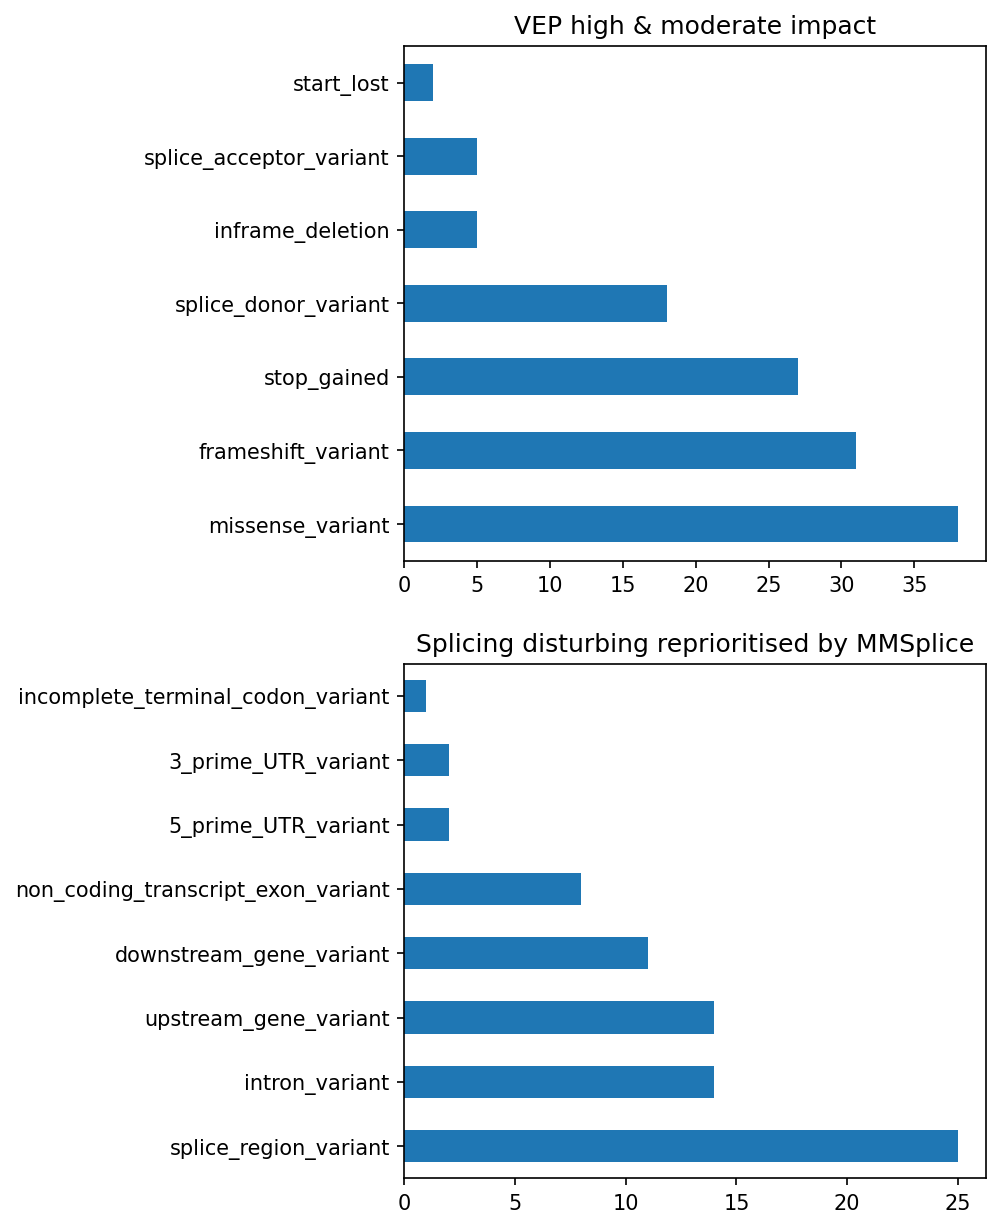

In [21]:
consequence = df_results[['Consequence']].reset_index().drop_duplicates()['Consequence'].str.split(',')

is_impact = consequence.map(lambda x: any(i in impacts for i in x))
vep_variant = consequence[is_impact].str.get(0).value_counts()
mmsplice_variants = consequence[~is_impact].str.get(0).value_counts()

plt.figure(figsize=(5, 10), dpi=150)
# axes = fig.subplots(nrows=1, ncols=2)
plt.subplot(2, 1, 1)
plt.title('VEP high & moderate impact')
vep_variant.plot.barh()
plt.subplot(2, 1, 2)
plt.title('Splicing disturbing reprioritised by MMSplice')
mmsplice_variants.plot.barh()

In [22]:
df_results[~df_results['cite'].isna()][columns].drop_duplicates()

gene_name               variant    IMPACT  \
geneID          sampleID                                                     
ENSG00000137601 CASE.NEUEK191WYC      NEK1    chr4:169424645:G>A      HIGH   
ENSG00000123240 CASE.NEUBK117YXL      OPTN    chr10:13122390:C>A      HIGH   
                CASE.NEUZT557DHF      OPTN  chr10:13112464:T>TAG      HIGH   
ENSG00000104133 CASE.NEUVX902YNL     SPG11    chr15:44620189:C>A      HIGH   
                CASE.NEUVX902YNL     SPG11    chr15:44620189:C>A      HIGH   
                CASE.NEUVX902YNL     SPG11    chr15:44620189:C>A  MODERATE   
                CASE.NEUVX902YNL     SPG11    chr15:44620189:C>A  MODERATE   

                                           CLIN_SIG  \
geneID          sampleID                              
ENSG00000137601 CASE.NEUEK191WYC                NaN   
ENSG00000123240 CASE.NEUBK117YXL                NaN   
                CASE.NEUZT557DHF                NaN   
ENSG00000104133 CASE.NEUVX902YNL  likely_pathogenic   
                CASE.NEUVX902YNL  likely_pathogenic   
                CASE.NEUVX902YNL  likely_pathogenic   
                CASE.NEUVX902YNL  likely_pathogenic   

                                                                        Consequence  \
geneID          sampleID                                                              
ENSG00000137601 CASE.NEUEK191WYC                                        stop_gained   
ENSG00000123240 CASE.NEUBK117YXL                                        stop_gained   
                CASE.NEUZT557DHF                                 frameshift_variant   
ENSG00000104133 CASE.NEUVX902YNL                               splice_donor_variant   
                CASE.NEUVX902YNL  splice_donor_variant,non_coding_transcript_var...   
                CASE.NEUVX902YNL                            downstream_gene_variant   
                CASE.NEUVX902YNL            missense_variant,NMD_transcript_variant   

                                  ppi_score  delta_logit_psi  \
geneID          sampleID                                       
ENSG00000137601 CASE.NEUEK191WYC   0.012235              NaN   
ENSG00000123240 CASE.NEUBK117YXL   0.012292              NaN   
                CASE.NEUZT557DHF   0.012292              NaN   
ENSG00000104133 CASE.NEUVX902YNL   0.012252        -4.764128   
                CASE.NEUVX902YNL   0.012252        -4.764128   
                CASE.NEUVX902YNL   0.012252        -4.764128   
                CASE.NEUVX902YNL   0.012252        -4.764128   

                                 polyphen_prediction  polyphen_score  \
geneID          sampleID                                               
ENSG00000137601 CASE.NEUEK191WYC                 NaN             NaN   
ENSG00000123240 CASE.NEUBK117YXL                 NaN             NaN   
                CASE.NEUZT557DHF                 NaN             NaN   
ENSG00000104133 CASE.NEUVX902YNL                 NaN             NaN   
                CASE.NEUVX902YNL                 NaN             NaN   
                CASE.NEUVX902YNL                 NaN             NaN   
                CASE.NEUVX902YNL   possibly_damaging           0.841   

                                  AberrantBySample  \
geneID          sampleID                             
ENSG00000137601 CASE.NEUEK191WYC                 7   
ENSG00000123240 CASE.NEUBK117YXL                 8   
                CASE.NEUZT557DHF                 4   
ENSG00000104133 CASE.NEUVX902YNL                24   
                CASE.NEUVX902YNL                24   
                CASE.NEUVX902YNL                24   
                CASE.NEUVX902YNL                24   

                                                                               cite  \
geneID          sampleID                                                              
ENSG00000137601 CASE.NEUEK191WYC                                Hardiman 2017,ALSoD   
ENSG00000123240 CASE.NEUBK117YXL  Nishiyama 2017,Goldstein 2016,Lamp 2018,Fa

In [23]:
df_results[df_results['CLIN_SIG'].isin({'likely_pathogenic', 'pathogenic'})][columns].drop_duplicates()

gene_name                         variant  \
geneID          sampleID                                                     
ENSG00000084774 CASE.NEUBD218YR3       CAD  chr2:27239368:TGCCCTTCTCCAAG>T   
ENSG00000162129 CASE.NEUGW326BRV      CLPB              chr11:72302312:G>A   
                CASE.NEUGW326BRV      CLPB              chr11:72302312:G>A   
ENSG00000104884 CASE.NEURR881FKY     ERCC2          chr19:45364832:CCTCA>C   
                CASE.NEURR881FKY     ERCC2          chr19:45364832:CCTCA>C   
ENSG00000182150 CASE.NEUTA689LN5   ERCC6L2               chr9:95955996:C>T   
                CASE.NEUTA689LN5   ERCC6L2               chr9:95955996:C>T   
ENSG00000151779 CASE.NEULY177TTN      NBAS              chr2:15534602:G>GA   
ENSG00000104320 CASE.NEUHM532NDD       NBN               chr8:89984524:C>T   
                CASE.NEUHM532NDD       NBN               chr8:89984524:C>T   
                CASE.NEUHM532NDD       NBN               chr8:89984524:C>T   
                CASE.NEUHM532NDD       NBN               chr8:89984524:C>T   
ENSG00000101310 CASE.NEUJA217MTJ    SEC23B              chr20:18524980:C>T   
ENSG00000104133 CASE.NEUVX902YNL     SPG11              chr15:44620189:C>A   
                CASE.NEUVX902YNL     SPG11              chr15:44620189:C>A   
                CASE.NEUVX902YNL     SPG11              chr15:44620189:C>A   
                CASE.NEUVX902YNL     SPG11              chr15:44620189:C>A   

                                    IMPACT           CLIN_SIG  \
geneID          sampleID                                        
ENSG00000084774 CASE.NEUBD218YR3      HIGH         pathogenic   
ENSG00000162129 CASE.NEUGW326BRV      HIGH         pathogenic   
                CASE.NEUGW326BRV  MODERATE         pathogenic   
ENSG00000104884 CASE.NEURR881FKY      HIGH  likely_pathogenic   
                CASE.NEURR881FKY      HIGH  likely_pathogenic   
ENSG00000182150 CASE.NEUTA689LN5      HIGH         pathogenic   
                CASE.NEUTA689LN5      HIGH         pathogenic   
ENSG00000151779 CASE.NEULY177TTN      HIGH         pathogenic   
ENSG00000104320 CASE.NEUHM532NDD      HIGH  likely_pathogenic   
                CASE.NEUHM532NDD      HIGH  likely_pathogenic   
                CASE.NEUHM532NDD  MODERATE  likely_pathogenic   
                CASE.NEUHM532NDD      HIGH  likely_pathogenic   
ENSG00000101310 CASE.NEUJA217MTJ      HIGH         pathogenic   
ENSG00000104133 CASE.NEUVX902YNL      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL  MODERATE  likely_pathogenic   
                CASE.NEUVX902YNL  MODERATE  likely_pathogenic   

                                                                        Consequence  \
geneID          sampleID                                                              
ENSG00000084774 CASE.NEUBD218YR3                                 frameshift_variant   
ENSG00000162129 CASE.NEUGW326BRV                                        stop_gained   
                CASE.NEUGW326BRV            missense_variant,NMD_transcript_variant   
ENSG00000104884 CASE.NEURR881FKY                splice_donor_variant,intron_variant   
                CASE.NEURR881FKY  splice_donor_variant,intron_variant,non_coding...   
ENSG00000182150 CASE.NEUTA689LN5                                        stop_gained   
                CASE.NEUTA689LN5                 stop_gained,NMD_transcript_variant   
ENSG00000151779 CASE.NEULY177TTN                                 frameshift_variant   
ENSG00000104320 CASE.NEUHM532NDD                               splice_donor_variant   
                CASE.NEUHM532NDD        splice_donor_variant,NMD_transcript_variant   
                CASE.NEUHM532NDD                              upstream_gene_variant   
                CASE.NEUHM532NDD  splice_donor_variant,non_coding_transcript_var...   
ENSG00000101310 CASE.NEUJA217MTJ                                        stop_gained   
ENSG00000

552476.0 0.0004186660221905242


<AxesSubplot:>

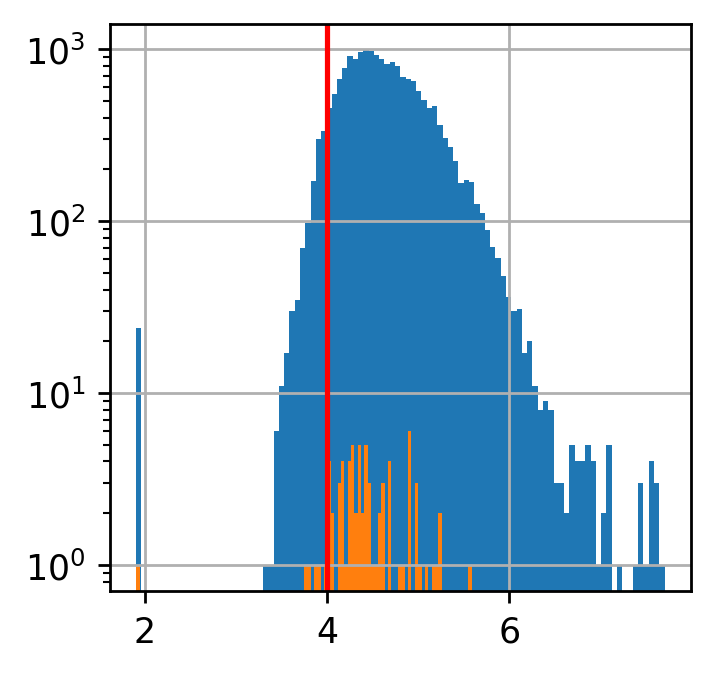

In [24]:
import numpy as np
plt.figure(figsize=(3, 3), dpi=250)

plt.axvline(4, c='r')

_df = df_ppi.join(df_results.reset_index('sampleID')[['sampleID']].drop_duplicates())
_df

from scipy.stats import mannwhitneyu

stats, pval = mannwhitneyu(
    _df[_df['sampleID'].isna()]['score'], 
    _df[~_df['sampleID'].isna()]['score'], 
    alternative='less')

print(stats, pval)

plt.yscale('log')

(-np.log10(_df[_df['sampleID'].isna()]['score'])).hist(bins=100)
(-np.log10(_df[~_df['sampleID'].isna()]['score'])).hist(bins=100)

552476.0 0.0004186660221905242


<AxesSubplot:>

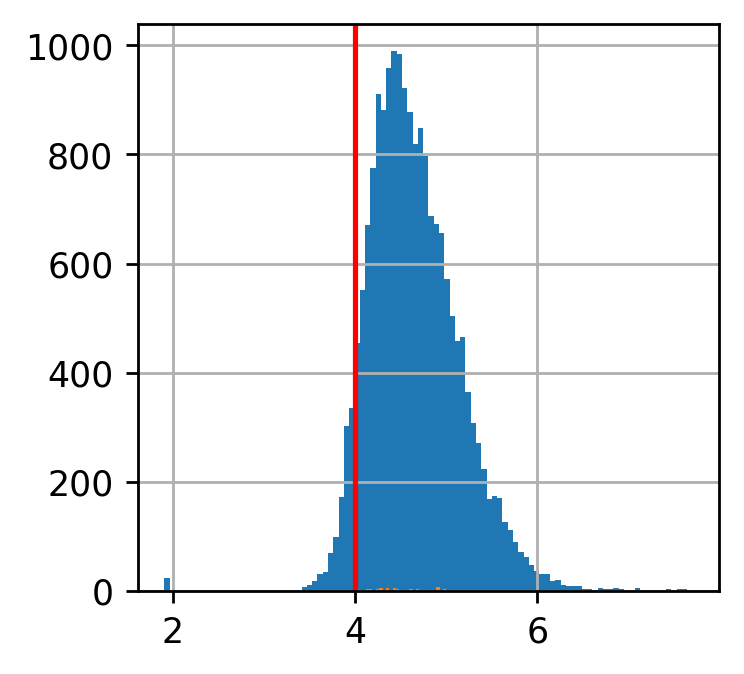

In [25]:
plt.figure(figsize=(3, 3), dpi=250)

print(stats, pval)

plt.axvline(4, c='r')

(-np.log10(_df[_df['sampleID'].isna()]['score'])).hist(bins=100)
(-np.log10(_df[~_df['sampleID'].isna()]['score'])).hist(bins=100)

In [26]:
df_results[df_results['ppi_score'] > 10**-4][columns].drop_duplicates()

gene_name                variant    IMPACT  \
geneID          sampleID                                                      
ENSG00000162129 CASE.NEUGW326BRV      CLPB     chr11:72302312:G>A      HIGH   
                CASE.NEUGW326BRV      CLPB     chr11:72302312:G>A  MODERATE   
ENSG00000105671 CASE.NEUDG000ZG5     DDX49     chr19:18920909:G>C  MODERATE   
                CASE.NEUDG000ZG5     DDX49     chr19:18920909:G>C  MODERATE   
                CASE.NEUDG000ZG5     DDX49     chr19:18920909:G>C  MODERATE   
                CASE.NEUDG000ZG5     DDX49     chr19:18920909:G>C  MODERATE   
                CASE.NEUDG000ZG5     DDX49     chr19:18920909:G>C  MODERATE   
                CASE.NEUDG000ZG5     DDX49     chr19:18920909:G>C  MODERATE   
                CASE.NEUDG000ZG5     DDX49     chr19:18920909:G>C  MODERATE   
ENSG00000170606 CASE.NEUPK546ZLD     HSPA4     chr5:133091236:C>T  MODERATE   
ENSG00000132305 CASE.NEUWD538KT3      IMMT      chr2:86181328:G>T      HIGH   
                CASE.NEUWD538KT3      IMMT      chr2:86181328:G>T      HIGH   
ENSG00000165264 CASE.NEUMY871DGF    NDUFB6      chr9:32572876:C>G  MODERATE   
ENSG00000137601 CASE.NEUEK191WYC      NEK1     chr4:169424645:G>A      HIGH   
ENSG00000101361 CASE.NEULD354RZB     NOP56      chr20:2655751:G>A  MODERATE   
                CASE.NEULD354RZB     NOP56      chr20:2655751:G>A  MODERATE   
                CASE.NEULD354RZB     NOP56      chr20:2655751:G>A  MODERATE   
                CASE.NEULD354RZB     NOP56      chr20:2655751:G>A  MODERATE   
                CASE.NEULD354RZB     NOP56      chr20:2655751:G>A  MODERATE   
                CASE.NEULD354RZB     NOP56      chr20:2655751:G>A  MODERATE   
ENSG00000123240 CASE.NEUBK117YXL      OPTN     chr10:13122390:C>A      HIGH   
                CASE.NEUZT557DHF      OPTN   chr10:13112464:T>TAG      HIGH   
ENSG00000143799 CASE.NEUAT234RK6     PARP1   chr1:226381173:CGA>C      HIGH   
ENSG00000115020 CASE.NEUME498PCJ   PIKFYVE    chr2:208352730:A>AT      HIGH   
ENSG00000039123 CASE.NEUYY225MNZ   SKIV2L2      chr5:55344625:G>A  MODERATE   
                CASE.NEUYY225MNZ   SKIV2L2      chr5:55344625:G>A  MODERATE   
                CASE.NEUYY225MNZ   SKIV2L2      chr5:55344625:G>A  MODERATE   
                CASE.NEUYY225MNZ   SKIV2L2      chr5:55344625:G>A  MODERATE   
ENSG00000104133 CASE.NEUVX902YNL     SPG11     chr15:44620189:C>A      HIGH   
                CASE.NEUVX902YNL     SPG11     chr15:44620189:C>A      HIGH   
                CASE.NEUVX902YNL     SPG11     chr15:44620189:C>A  MODERATE   
                CASE.NEUVX902YNL     SPG11     chr15:44620189:C>A  MODERATE   
ENSG00000178952 CASE.NEUTA689LN5      TUFM     chr16:28844814:G>A      HIGH   
ENSG00000160803 CASE.NEUJA217MTJ    UBQLN4     chr1:156051242:C>T  MODERATE   
ENSG00000010256 CTRL.NEUMT184NWC    UQCRC1  chr3:48600726:CACAG>C      HIGH   

                                                CLIN_SIG  \
geneID          sampleID                                   
ENSG00000162129 CASE.NEUGW326BRV              pathogenic   
                CASE.NEUGW326BRV              pathogenic   
ENSG00000105671 CASE.NEUDG000ZG5                     NaN   
                CASE.NEUDG000ZG5                     NaN   
                CASE.NEUDG000ZG5                     NaN   
                CASE.NEUDG000ZG5                     NaN   
                CASE.NEUDG000ZG5                     NaN   
                CASE.NEUDG000ZG5                     NaN   
                CASE.NEUDG000ZG5                     NaN   
ENSG00000170606 CASE.NEUPK546ZLD                     NaN   
ENSG00000132305 CASE.NEUWD538KT3                     NaN   
                CASE.NEUWD538KT3                     NaN   
ENSG00000165264 CASE.NEUMY871DGF                     NaN   
ENSG00000137601 CASE.NEUEK191WYC                     NaN   
ENSG00000101361 CASE.NEULD354RZB                     NaN   
                CASE.NEULD354RZB                     NaN   
                CASE.NEULD354

In [27]:
len(set(df_results[df_results['ppi_score'] > 10**-4]['gene_name']))

15

In [28]:
df_results

gene_name        pValue   padjust  zScore  \
geneID          sampleID                                                     
ENSG00000131043 CASE.NEUGP781PDU      AAR2  2.316955e-10  0.000015   -6.67   
                CASE.NEUGP781PDU      AAR2  2.316955e-10  0.000015   -6.67   
                CASE.NEUGP781PDU      AAR2  2.316955e-10  0.000015   -6.67   
ENSG00000064687 CASE.NEUZP278MR4     ABCA7  2.026550e-07  0.001430    4.85   
                CASE.NEUZP278MR4     ABCA7  2.026550e-07  0.001430    4.85   
...                                    ...           ...       ...     ...   
ENSG00000197128 CASE.NEUHW530WD8    ZNF772  2.897211e-09  0.000026   -6.31   
                CASE.NEUHW530WD8    ZNF772  2.897211e-09  0.000026   -6.31   
                CASE.NEUHW530WD8    ZNF772  2.897211e-09  0.000026   -6.31   
ENSG00000196267 CASE.NEULZ548ZXV    ZNF836  1.397000e-09  0.000266   -6.44   
                CASE.NEULZ548ZXV    ZNF836  1.397000e-09  0.000266   -6.44   

                                  l2fc  rawcounts  normcounts  meanCorrected  \
geneID          sampleID                                                       
ENSG00000131043 CASE.NEUGP781PDU -0.54        614      635.96         924.95   
                CASE.NEUGP781PDU -0.54        614      635.96         924.95   
                CASE.NEUGP781PDU -0.54        614      635.96         924.95   
ENSG00000064687 CASE.NEUZP278MR4  0.59       4036     3248.64        2168.73   
                CASE.NEUZP278MR4  0.59       4036     3248.64        2168.73   
...                                ...        ...         ...            ...   
ENSG00000197128 CASE.NEUHW530WD8 -1.28        905      593.40        1433.71   
                CASE.NEUHW530WD8 -1.28        905      593.40        1433.71   
                CASE.NEUHW530WD8 -1.28        905      593.40        1433.71   
ENSG00000196267 CASE.NEULZ548ZXV -0.82        276      289.79         511.43   
                CASE.NEULZ548ZXV -0.82        276      289.79         511.43   

                                   theta  aberrant  ...  condel_prediction  \
geneID          sampleID                            ...                      
ENSG00000131043 CASE.NEUGP781PDU  552.86      True  ...                NaN   
                CASE.NEUGP781PDU  552.86      True  ...                NaN   
                CASE.NEUGP781PDU  552.86      True  ...                NaN   
ENSG00000064687 CASE.NEUZP278MR4  147.07      True  ...                NaN   
                CASE.NEUZP278MR4  147.07      True  ...                NaN   
...                                  ...       ...  ...                ...   
ENSG00000197128 CASE.NEUHW530WD8   62.45      True  ...        deleterious   
                CASE.NEUHW530WD8   62.45      True  ...        deleterious   
                CASE.NEUHW530WD8   62.45      True  ...        deleterious   
ENSG00000196267 CASE.NEULZ548ZXV  212.23      True  ...                NaN   
                CASE.NEULZ548ZXV  212.23      True  ...                NaN   

                                  condel_score  sift_prediction  sift_score  \
geneID          sampleID                                                      
ENSG00000131043 CASE.NEUGP781PDU           NaN              NaN         NaN   
                CASE.NEUGP781PDU           NaN              NaN         NaN   
                CASE.NEUGP781PDU           NaN              NaN         NaN   
ENSG00000064687 CASE.NEUZP278MR4           NaN              NaN         NaN   
                CASE.NEUZP278MR4           NaN              NaN         NaN   
...                                        ...              ...         ...   
ENSG00000197128 CASE.NEUHW530WD8         0.831      deleterious        0.03   
                CASE.NEUHW530WD8         0.790        tolerated        0.08   
                CASE.NEUHW530WD8         0.823        tolerated        0.06   
ENSG00000196267 CASE.NEULZ548ZXV           NaN              NaN         NaN   
              

In [29]:
df_results.to_csv(snakemake.output['results_variants'])